In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import zipfile
import os

In [ ]:
from google.colab import files
import zipfile
import os

uploaded = files.upload()  # Upload archive.zip

with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')

os.listdir('dataset')


Saving archive.zip to archive.zip


['movies_genres.csv', 'movies_overview.csv']

In [ ]:
#Load DataFrames
import pandas as pd
import ast

genres_df = pd.read_csv('dataset/movies_genres.csv')
overview_df = pd.read_csv('dataset/movies_overview.csv')

# Convert genre_ids from string to actual list
overview_df['genre_ids'] = overview_df['genre_ids'].apply(ast.literal_eval)

# Explode genre IDs to merge genre names
exploded_df = overview_df.explode('genre_ids')
merged_df = exploded_df.merge(genres_df, left_on='genre_ids', right_on='id', how='left')

# Re-group genres per movie
grouped_df = merged_df.groupby(['title', 'overview']).agg({'name': list}).reset_index()
grouped_df.rename(columns={'name': 'genres'}, inplace=True)

# Add text length and number of genres
grouped_df['overview_length'] = grouped_df['overview'].apply(lambda x: len(x.split()))
grouped_df['num_genres'] = grouped_df['genres'].apply(len)

grouped_df.head()


,title,overview,genres,overview_length,num_genres
0,#Alive,"As a grisly virus rampages a city, a lone man ...","[Action, Horror]",28,2
1,#realityhigh,When nerdy high schooler Dani finally attracts...,[Comedy],26,1
2,'71,A young British soldier must find his way back...,"[Thriller, Action, Drama, War]",25,4
3,(500) Days of Summer,"Tom, greeting-card writer and hopeless romanti...","[Comedy, Drama, Romance]",46,3
4,(T)Raumschiff Surprise - Periode 1,Hundreds of years after humans have settled on...,"[Comedy, Science Fiction, Adventure]",51,3


In [ ]:
#Check for Missing Values

print(" Missing values in overview dataset:\n")
print(overview_df.isnull().sum())

print("\n Missing values in genres dataset:\n")
print(genres_df.isnull().sum())


🔍 Missing values in overview dataset:

title        0
overview     0
genre_ids    0
dtype: int64

🔍 Missing values in genres dataset:

id      0
name    0
dtype: int64


In [ ]:
# Dataset Summaries

print(" Overview Dataset Summary:\n")
print(overview_df.describe(include='all'))

print("\n Genres Dataset Summary:\n")
print(genres_df.describe(include='all'))


🎬 Overview Dataset Summary:

         title                                           overview genre_ids
count     9980                                               9980      9980
unique    9615                                               9971      2222
top     Return  Young businessman Thomas Crown is bored and de...      [18]
freq        13                                                  2       577

🎭 Genres Dataset Summary:

                  id    name
count      19.000000      19
unique           NaN      19
top              NaN  Action
freq             NaN       1
mean     3389.736842     NaN
std      4980.456972     NaN
min        12.000000     NaN
25%        27.500000     NaN
50%        53.000000     NaN
75%     10025.000000     NaN
max     10770.000000     NaN


In [ ]:
#  Detect Outliers using IQR
def detect_outliers_iqr(column):
    Q1 = grouped_df[column].quantile(0.25)
    Q3 = grouped_df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = grouped_df[(grouped_df[column] < lower_bound) | (grouped_df[column] > upper_bound)]
    return outliers[[column]]

# Detect outliers for overview_length
outliers_overview = detect_outliers_iqr('overview_length')

# Detect outliers for num_genres
outliers_genres = detect_outliers_iqr('num_genres')

print(" Outliers in 'overview_length':")
print(outliers_overview)

print("\n Outliers in 'num_genres':")
print(outliers_genres)


 Outliers in 'overview_length':
      overview_length
145               117
200               163
310               121
469               129
477               125
...               ...
9674              116
9834              146
9838              114
9914              117
9947              117

[150 rows x 1 columns]

 Outliers in 'num_genres':
      num_genres
31             5
93             5
110            5
138            5
165            7
...          ...
9815           5
9818           5
9871           5
9877           5
9950           5

[486 rows x 1 columns]


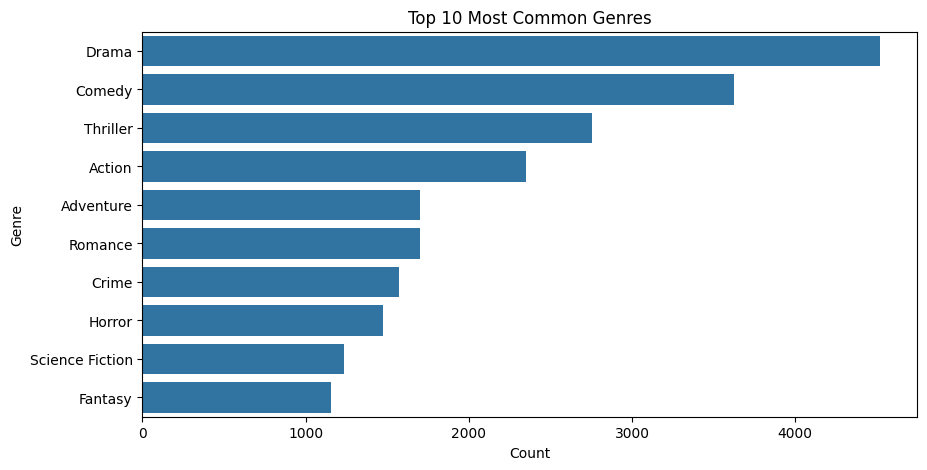

In [ ]:
#  Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Top 10 genres (by occurrence)
all_genres = merged_df['name'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=all_genres.values, y=all_genres.index)
plt.title("Top 10 Most Common Genres")
plt.xlabel("Count")
plt.ylabel("Genre")
plt.show()


This bar chart shows the top 10 most common movie genres in the dataset based on frequency. Drama and Comedy are the most represented, followed by Thriller, Action, and Adventure. The graph highlights the dominance of emotionally driven and action-packed genres in modern cinema.









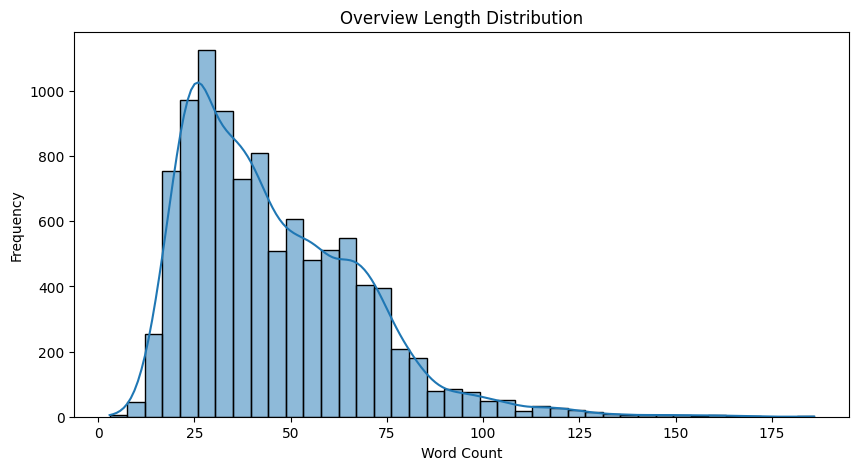

In [ ]:
#Overview length distribution
plt.figure(figsize=(10,5))
sns.histplot(grouped_df['overview_length'], bins=40, kde=True)
plt.title("Overview Length Distribution")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()


histogram visualizes the distribution of movie overview lengths. It uses sns.histplot to display the frequency of different word counts in movie overviews, with 40 bins and a kernel density estimate for a smoother curve.

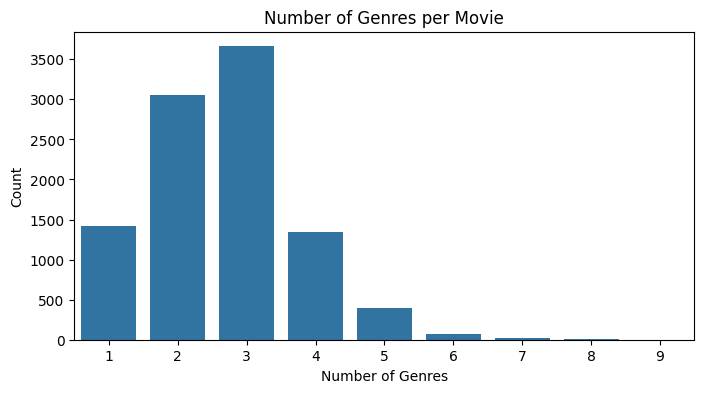

In [ ]:
#  Number of genres per movie
plt.figure(figsize=(8,4))
sns.countplot(x='num_genres', data=grouped_df)
plt.title("Number of Genres per Movie")
plt.xlabel("Number of Genres")
plt.ylabel("Count")
plt.show()


This bar chart shows the number of genres assigned per movie. Most movies are tagged with 2 or 3 genres, with 3 being the most common. Very few movies have more than 5 genres, indicating that multi-genre tagging is typically limited to a small set.



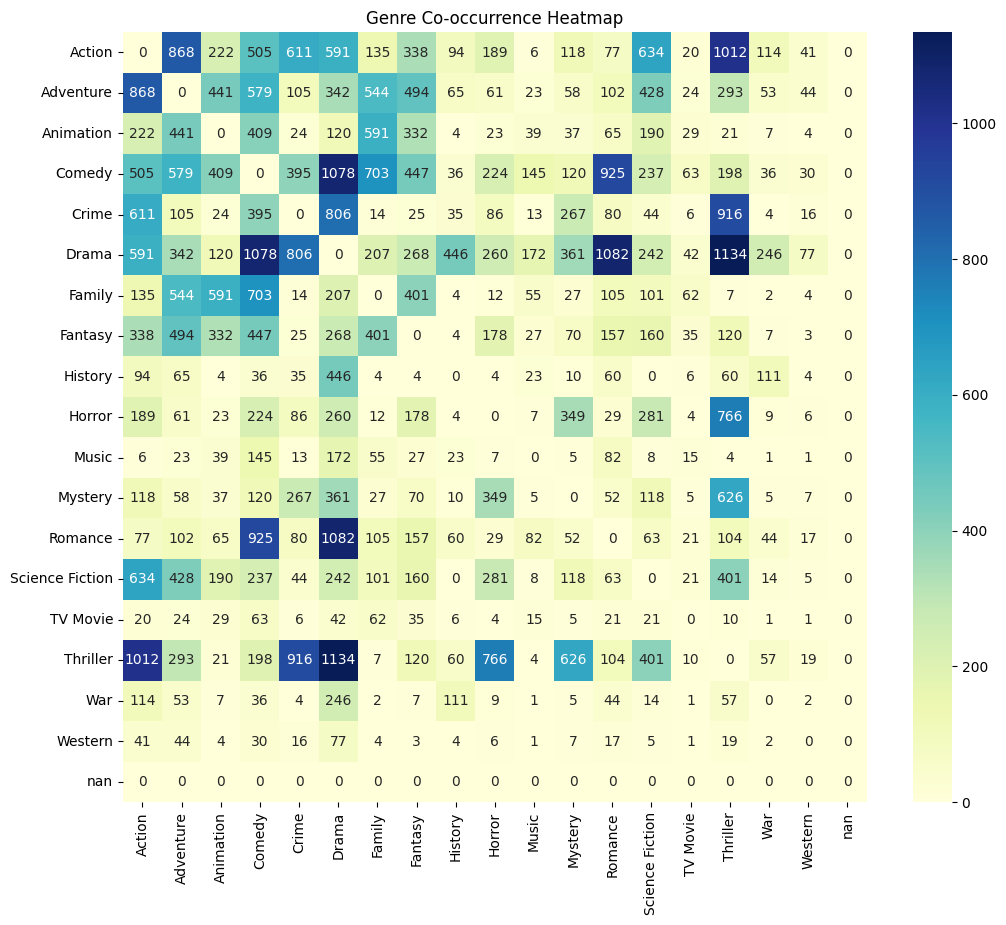

In [ ]:
# Create a binary matrix (movies x genres)
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

# Ensure all elements within the 'genres' lists are strings
grouped_df['genres'] = grouped_df['genres'].apply(lambda x: [str(i) for i in x])

genre_matrix = pd.DataFrame(
    mlb.fit_transform(grouped_df['genres']),
    columns=mlb.classes_,
    index=grouped_df['title']
)

#  Create co-occurrence matrix
co_occurrence = genre_matrix.T.dot(genre_matrix)

# Set diagonal to 0 (genre with itself)
import numpy as np
np.fill_diagonal(co_occurrence.values, 0)

# Plot Heatmap
plt.figure(figsize=(12,10))
sns.heatmap(co_occurrence, cmap="YlGnBu", annot=True, fmt="d")
plt.title("Genre Co-occurrence Heatmap")
plt.show()


The heatmap shows that Drama frequently co-occurs with genres like Thriller, Romance, and Crime. Strong pairings are also seen between Action & Adventure and Comedy & Romance. This highlights popular genre combinations used in multi-genre films for broader audience appeal.

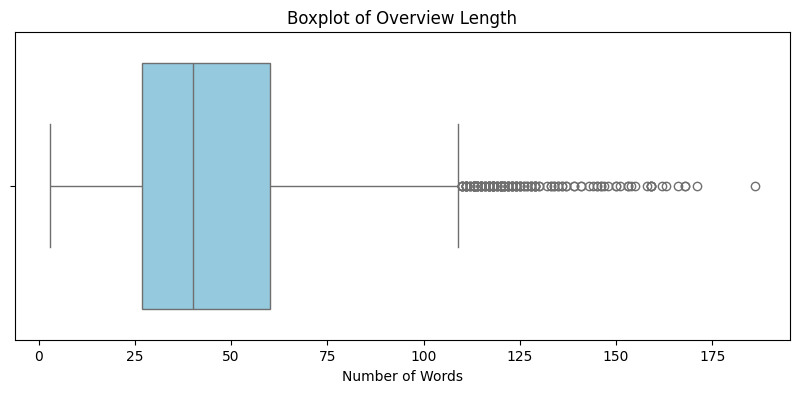

In [ ]:
# Boxplots to visualize outliers
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot for overview length
plt.figure(figsize=(10, 4))
sns.boxplot(x=grouped_df['overview_length'], color='skyblue')
plt.title('Boxplot of Overview Length')
plt.xlabel('Number of Words')
plt.show()


This boxplot displays the distribution of movie overview lengths by word count. Most overviews fall between 25 to 100 words, while values beyond that are treated as outliers. These outliers suggest a subset of movies have significantly more detailed descriptions.

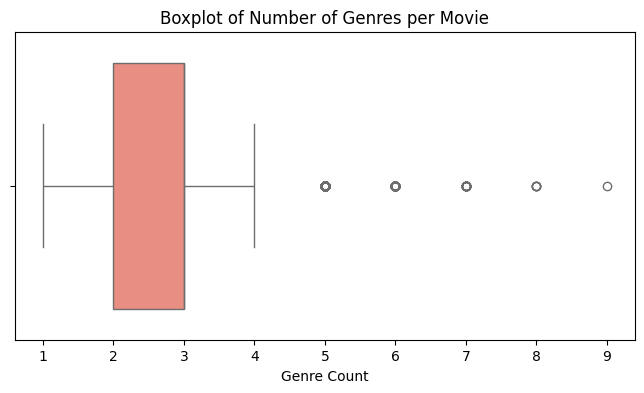

In [ ]:
# Boxplot for number of genres
plt.figure(figsize=(8, 4))
sns.boxplot(x=grouped_df['num_genres'], color='salmon')
plt.title('Boxplot of Number of Genres per Movie')
plt.xlabel('Genre Count')
plt.show()


This boxplot illustrates the distribution of the number of genres per movie. Most films have between 2 to 4 genres, with 3 being the median. Values above 5 are considered outliers, indicating a few movies are tagged with many genres.

<ipython-input-33-a7c31e3520d9>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
<ipython-input-33-a7c31e3520d9>:23: UserWarning: Glyph 128218 (\N{BOOKS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128218 (\N{BOOKS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


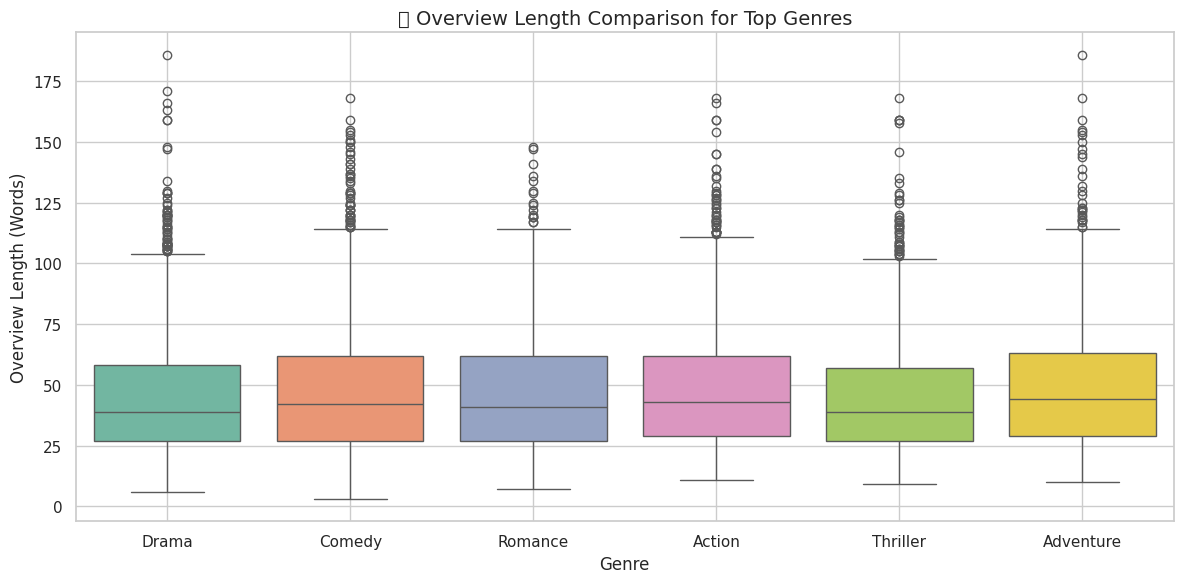

In [ ]:


# Get top 6 most frequent genres
top_genres = merged_df['name'].value_counts().nlargest(6).index.tolist()

# Filter merged_df to keep only those top genres
top_genres_df = merged_df[merged_df['name'].isin(top_genres)]

# Merge overview_length into this filtered dataset
top_genres_df = top_genres_df.merge(grouped_df[['title', 'overview_length']], on='title')

#  Boxplot of overview length grouped by genre
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=top_genres_df,
    x='name',
    y='overview_length',
    palette='Set2'
)

plt.title("Overview Length Comparison for Top Genres", fontsize=14)
plt.xlabel("Genre")
plt.ylabel("Overview Length (Words)")
plt.grid(True)
plt.tight_layout()
plt.show()


This boxplot compares the distribution of overview lengths across the top 6 most frequent genres. While median word counts are fairly similar, Adventure and Comedy tend to have slightly longer descriptions. All genres show many outliers, indicating some movies have unusually detailed overviews regardless of genre.

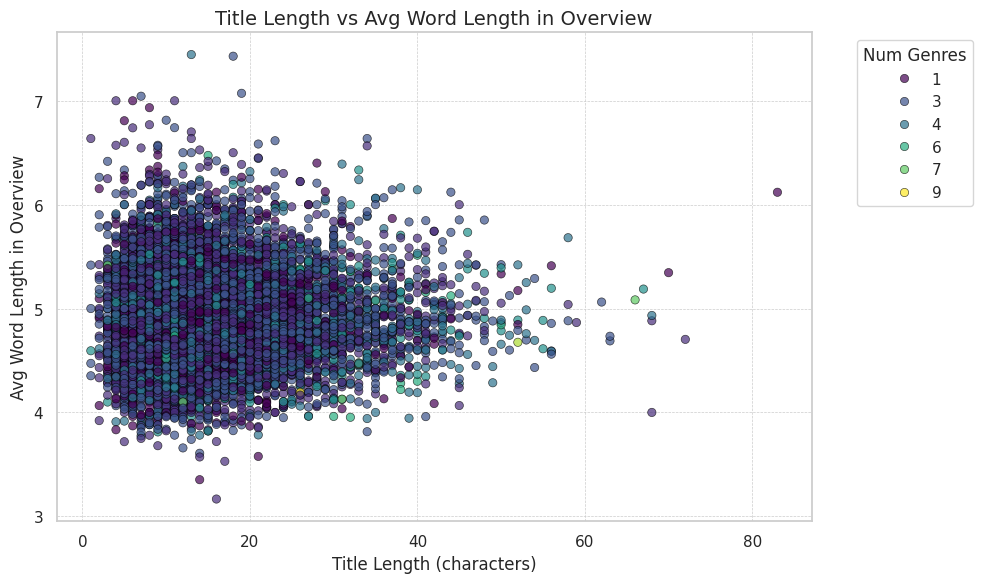

In [ ]:
# Feature Engineering
grouped_df['title_length'] = grouped_df['title'].apply(len)
grouped_df['avg_word_length'] = grouped_df['overview'].apply(
    lambda x: sum(len(word) for word in x.split()) / len(x.split()) if len(x.split()) > 0 else 0
)
# Scatter Plot
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=grouped_df,
    x='title_length',
    y='avg_word_length',
    hue='num_genres',
    palette='viridis',
    alpha=0.7,
    edgecolor='black'
)

plt.title("Title Length vs Avg Word Length in Overview", fontsize=14)
plt.xlabel("Title Length (characters)")
plt.ylabel("Avg Word Length in Overview")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(title='Num Genres', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


This scatter plot shows the relationship between title length and average word length in overviews, colored by the number of genres. Most movies have titles under 30 characters and use words averaging 4 to 6 characters in overviews. There's no strong correlation, but we observe that movies with a wider genre range (colored differently) are slightly more spread out in terms of complexity and title length.

<ipython-input-32-4c31820d78d1>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=overview_bar.values, y=overview_bar.index, palette='Blues_r')
<ipython-input-32-4c31820d78d1>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=title_bar.values, y=title_bar.index, palette='Purples_r')
<ipython-input-32-4c31820d78d1>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_genres.values, y=top_genres.index, palette='Greens_r')
<ipython-input-32-4c31820d78d1>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and wil

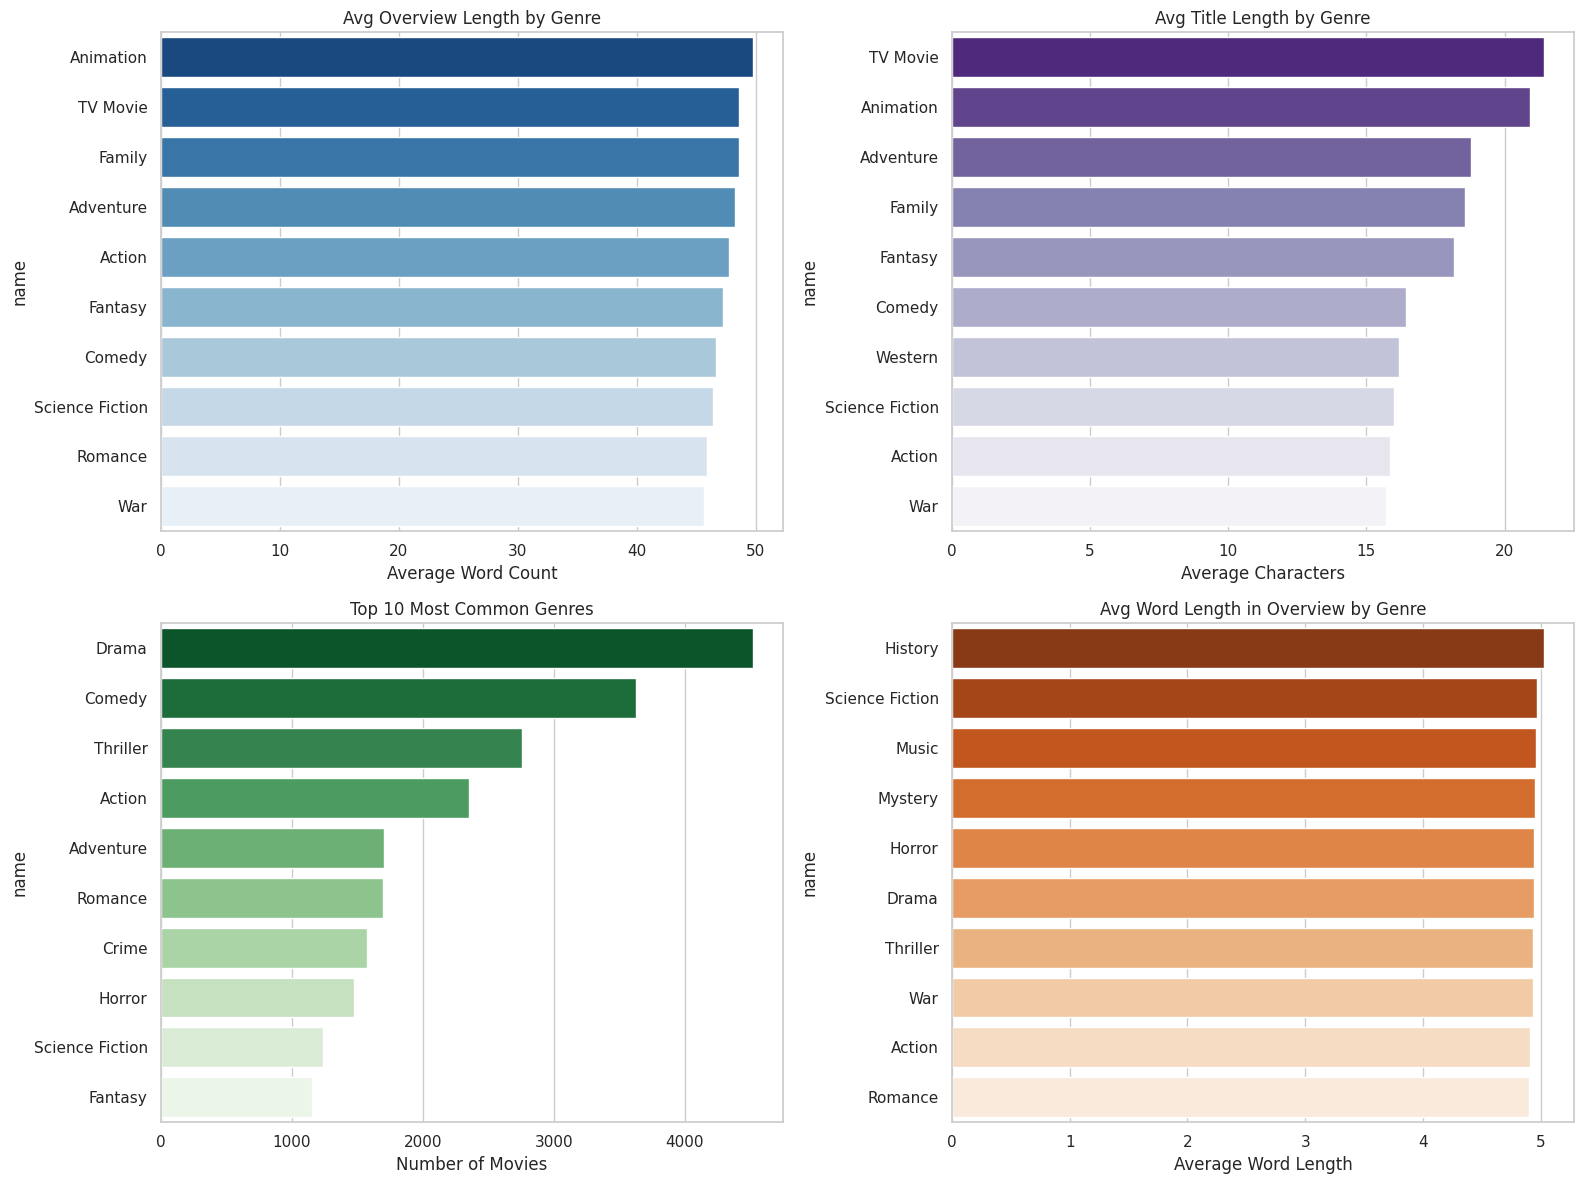

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(16, 12))

# Prepare per-genre stats
merged_df_stats = merged_df.merge(grouped_df[['title', 'overview_length', 'title_length', 'avg_word_length']], on='title')

# 1. Avg overview length per genre
plt.subplot(2, 2, 1)
overview_bar = merged_df_stats.groupby('name')['overview_length'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=overview_bar.values, y=overview_bar.index, palette='Blues_r')
plt.title("Avg Overview Length by Genre")
plt.xlabel("Average Word Count")

# 2. Avg title length per genre
plt.subplot(2, 2, 2)
title_bar = merged_df_stats.groupby('name')['title_length'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=title_bar.values, y=title_bar.index, palette='Purples_r')
plt.title("Avg Title Length by Genre")
plt.xlabel("Average Characters")

# 3. Top genres by number of movies
plt.subplot(2, 2, 3)
top_genres = merged_df['name'].value_counts().head(10)
sns.barplot(x=top_genres.values, y=top_genres.index, palette='Greens_r')
plt.title("Top 10 Most Common Genres")
plt.xlabel("Number of Movies")

# 4. Avg word length in overview by genre
plt.subplot(2, 2, 4)
avg_word_bar = merged_df_stats.groupby('name')['avg_word_length'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=avg_word_bar.values, y=avg_word_bar.index, palette='Oranges_r')
plt.title("Avg Word Length in Overview by Genre")
plt.xlabel("Average Word Length")

plt.tight_layout()
plt.show()


This dashboard compares genre-based averages for overview length, title length, and word complexity. Animation and TV Movies have the longest overviews and titles, while Drama is the most frequent genre. History and Sci-Fi use the most complex vocabulary in movie descriptions.
